In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
np.random.seed(42)


In [14]:
df = pd.read_csv('data-churn.csv')
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [15]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [17]:
print("Tamaño del dataset:", df.shape)

print(df["Churn"].value_counts(normalize=True).rename("proporción"))

df.describe(include="all").transpose().head(20)


Tamaño del dataset: (7043, 21)
Churn
0    0.73463
1    0.26537
Name: proporción, dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
numeric_features = [
    "MonthlyCharges",
    "TotalCharges",
    "tenure"
]

categorical_features = [
    "Contract",
    "InternetService",
    "PaymentMethod",
    "PhoneService"
]

X = df[numeric_features + categorical_features]
y = df["Churn"]


In [19]:
for col in numeric_features:
    X[col] = pd.to_numeric(X[col], errors="coerce")

C:\Users\fperezg\AppData\Local\Temp\ipykernel_21776\27114591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors="coerce")


In [20]:
X = X.dropna()
y = y[X.index]

In [21]:
numeric_transformer_base = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_base = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_base, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [22]:
def evaluate_model_cv(model, X, y, cv_splits=5):
    """
    Ejecuta k-fold CV estratificada y:
    - Ajusta el modelo en cada fold
    - Acumula predicciones y probabilidades
    - Muestra matriz de confusión, reporte, ROC, PR
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    y_true_all = []
    y_pred_all = []
    y_proba_all = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
        y_proba_all.extend(y_proba)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)
    y_proba_all = np.array(y_proba_all)

    # Matriz de confusión
    cm = confusion_matrix(y_true_all, y_pred_all)
    print("Matriz de confusión global (todos los folds):")
    print(cm)

    # Reporte de clasificación
    print("Reporte de clasificación:")
    print(classification_report(y_true_all, y_pred_all, digits=3))

    # ROC
    fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("Curva ROC (CV global)")
    plt.legend()
    plt.show()

    # Precision–Recall
    precision, recall, _ = precision_recall_curve(y_true_all, y_proba_all)
    pr_auc = average_precision_score(y_true_all, y_proba_all)

    plt.figure()
    plt.step(recall, precision, where="post", label=f"PR (AP = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision–Recall (CV global)")
    plt.legend()
    plt.show()

    print(f"AUC-ROC global: {roc_auc:.3f}")
    print(f"PR-AUC (Average Precision) global: {pr_auc:.3f}")

    return {
        "cm": cm,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }


In [23]:
X

,MonthlyCharges,TotalCharges,tenure,Contract,InternetService,PaymentMethod,PhoneService
0,29.85,29.85,1,Month-to-month,DSL,Electronic check,No
1,56.95,1889.50,34,One year,DSL,Mailed check,Yes
2,53.85,108.15,2,Month-to-month,DSL,Mailed check,Yes
3,42.30,1840.75,45,One year,DSL,Bank transfer (automatic),No
4,70.70,151.65,2,Month-to-month,Fiber optic,Electronic check,Yes
...,...,...,...,...,...,...,...
7038,84.80,1990.50,24,One year,DSL,Mailed check,Yes
7039,103.20,7362.90,72,One year,Fiber optic,Credit card (automatic),Yes
7040,29.60,346.45,11,Month-to-month,DSL,Electronic check,No
7041,74.40,306.60,4,Month-to-month,Fiber optic,Mailed check,Yes


Matriz de confusión global (todos los folds):
[[4610  553]
 [ 885  984]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.839     0.893     0.865      5163
           1      0.640     0.526     0.578      1869

    accuracy                          0.796      7032
   macro avg      0.740     0.710     0.721      7032
weighted avg      0.786     0.796     0.789      7032



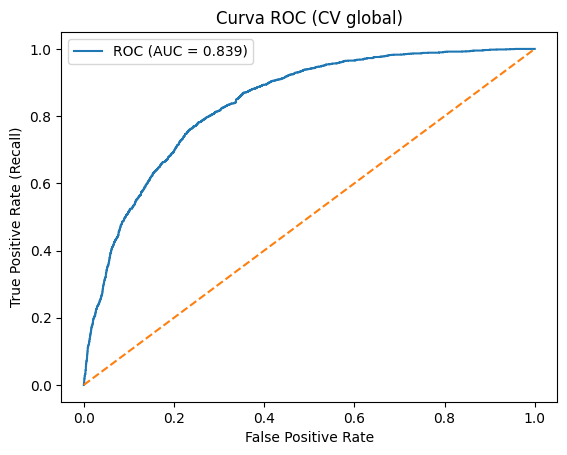

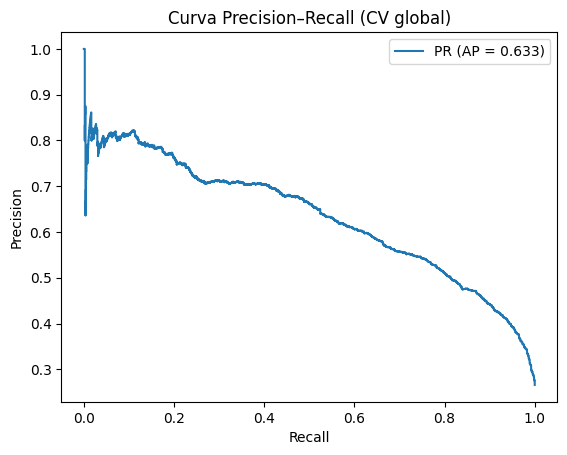

AUC-ROC global: 0.839
PR-AUC (Average Precision) global: 0.633


In [24]:
log_reg_base = Pipeline(steps=[
    ("preprocess", preprocessor_base),
    ("clf", LogisticRegression(
        penalty="l2",   # C grande ≈ sin regularización fuerte
        C=1e6,
        solver="lbfgs",
        max_iter=1000
    ))
])


results_base = evaluate_model_cv(log_reg_base, X, y, cv_splits=5)


Matriz de confusión global (todos los folds):
[[4704  459]
 [ 969  900]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.829     0.911     0.868      5163
           1      0.662     0.482     0.558      1869

    accuracy                          0.797      7032
   macro avg      0.746     0.696     0.713      7032
weighted avg      0.785     0.797     0.786      7032



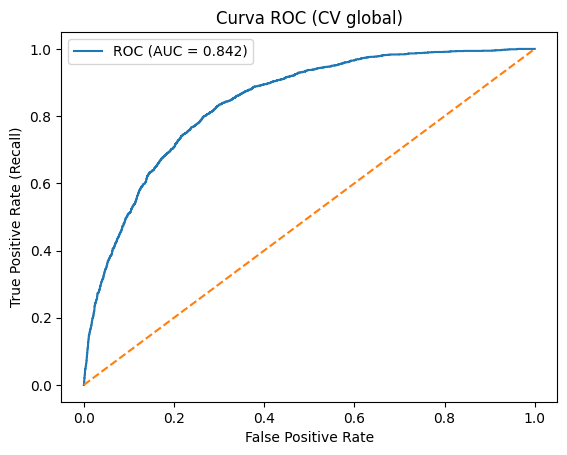

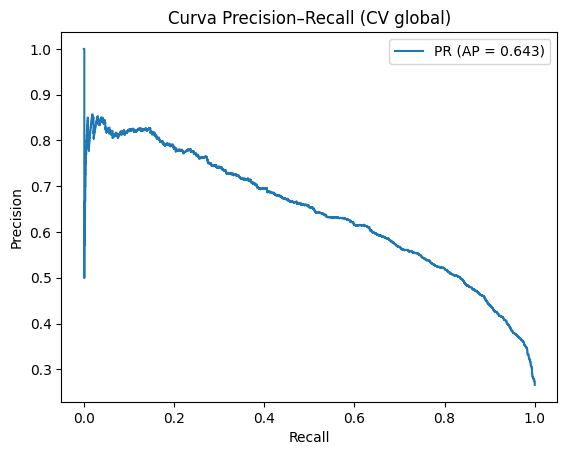

AUC-ROC global: 0.842
PR-AUC (Average Precision) global: 0.643


In [25]:
numeric_transformer_poly = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=4, include_bias=False))
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_poly, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

log_reg_poly = Pipeline(steps=[
    ("preprocess", preprocessor_poly),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1e6,
        solver="lbfgs",
        max_iter=1000
    ))
])

results_poly = evaluate_model_cv(log_reg_poly, X, y, cv_splits=5)


In [26]:
base_pipeline_poly = Pipeline(steps=[
    ("preprocess", preprocessor_poly),
    ("clf", LogisticRegression(max_iter=1000))
])


In [27]:
param_grid_l2 = {
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"],
    "clf__C": [0.01, 0.1, 1.0, 10.0]
}

grid_l2 = GridSearchCV(
    base_pipeline_poly,
    param_grid_l2,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="average_precision",  # PR-AUC
    n_jobs=-1
)

grid_l2.fit(X, y)

print("Mejores hiperparámetros (L2):", grid_l2.best_params_)
print("Mejor PR-AUC medio (L2):", grid_l2.best_score_)

best_model_l2 = grid_l2.best_estimator_


Mejores hiperparámetros (L2): {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Mejor PR-AUC medio (L2): 0.6465930113620735


In [28]:
param_grid_l1 = {
    "clf__penalty": ["l1"],
    "clf__solver": ["liblinear"],
    "clf__C": [0.01, 0.1, 1.0, 10.0]
}

grid_l1 = GridSearchCV(
    base_pipeline_poly,
    param_grid_l1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="average_precision",
    n_jobs=-1
)

grid_l1.fit(X, y)

print("Mejores hiperparámetros (L1):", grid_l1.best_params_)
print("Mejor PR-AUC medio (L1):", grid_l1.best_score_)

best_model_l1 = grid_l1.best_estimator_


Mejores hiperparámetros (L1): {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mejor PR-AUC medio (L1): 0.6464415710738256


Matriz de confusión global (todos los folds):
[[4717  446]
 [ 968  901]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.830     0.914     0.870      5163
           1      0.669     0.482     0.560      1869

    accuracy                          0.799      7032
   macro avg      0.749     0.698     0.715      7032
weighted avg      0.787     0.799     0.787      7032



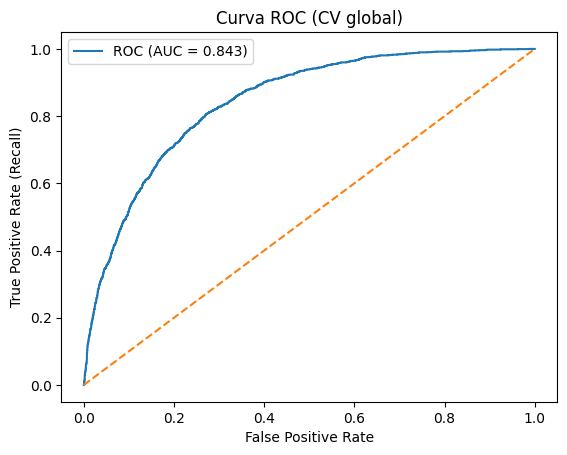

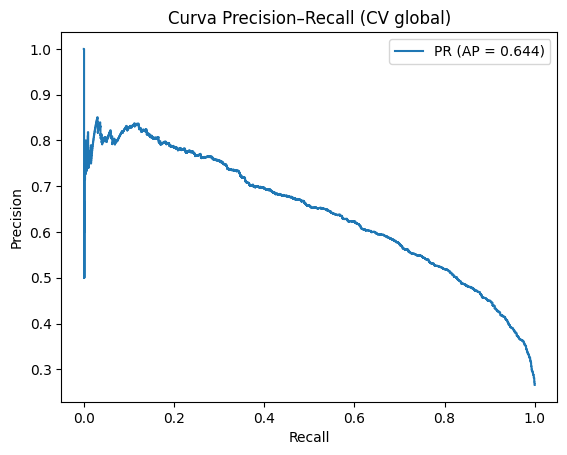

AUC-ROC global: 0.843
PR-AUC (Average Precision) global: 0.644
Matriz de confusión global (todos los folds):
[[4707  456]
 [ 958  911]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.831     0.912     0.869      5163
           1      0.666     0.487     0.563      1869

    accuracy                          0.799      7032
   macro avg      0.749     0.700     0.716      7032
weighted avg      0.787     0.799     0.788      7032



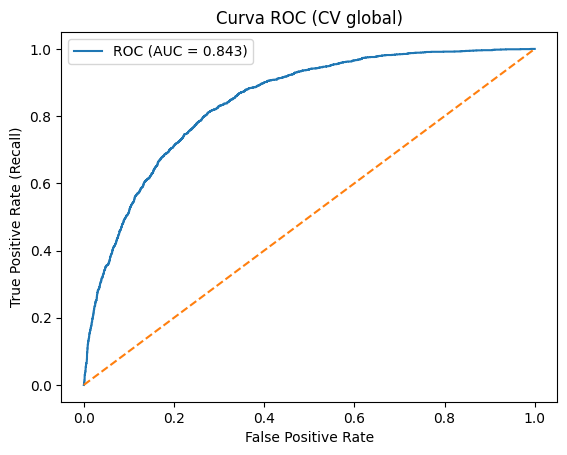

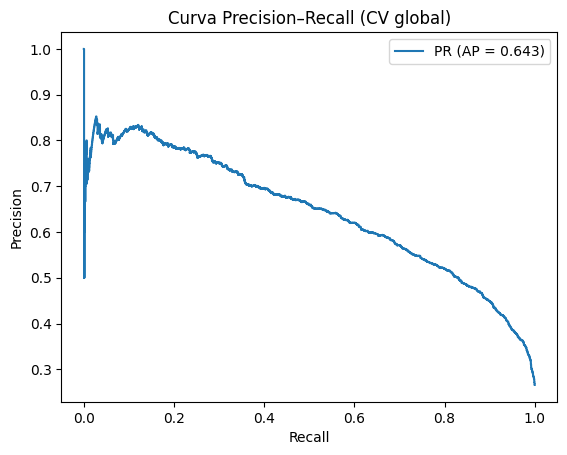

AUC-ROC global: 0.843
PR-AUC (Average Precision) global: 0.643


In [29]:
results_l2 = evaluate_model_cv(best_model_l2, X, y, cv_splits=5)

results_l1 = evaluate_model_cv(best_model_l1, X, y, cv_splits=5)
